# Conformal Inference
Julian Hsu
5jun2022

In this notebook we look at the idea of conformal inference from *Chernozhukov, Wuthrich, and Zhu* : https://arxiv.org/abs/1712.09089. 


In [3]:

import sys
import os
print (os.getcwd() )


import seaborn as sns

import pandas as pd
import numpy as np
import itertools
import math
import scipy
import functools
import sklearn as sk
from sklearn import impute, pipeline

%matplotlib inline
import matplotlib.pyplot as plt


pd.options.mode.chained_assignment = None  # default='warn'



/Users/hsujulia/Documents/GitHub/causalinference_crashcourse/OtherMaterial


In [4]:
data_settings = {'time units': 10,
                'x_units':30,
                 'K_dim':10,
                'treatment': 10}

In [5]:
## Function to automatically give us a panel dataset
def synth_panel(seed_number = 2123, 
                time_units = 10, 
                x_units = 30, 
                K_dim = 5,
               treatment_type = 'both',
               treatment_imp = 10,
               treatment_het = False):
    '''
    seed_number  random_number_set
    time_units   how many time periods?
    x_units      how many units?
    K_dim        how many covariates (assume uniform)
    treatment_type    how is treatment determined? {'X','Y', 'both'}
    treatment_imp     the level of treatment effect, constant for all post-treatment times
    '''
    ## Set the seed for random number
    xfun = np.random.RandomState(seed_number)
    
    ## Construct covariates, time-invariant fixed effects, and first period outcome
    X = xfun.uniform(low=0, high=1, size= (x_units, K_dim) )
    X_coef = xfun.uniform(low=-2, high=2, size = K_dim)
    x_list = ['x'+str(k) for k in range(K_dim)]
    
    
    fe = xfun.normal(0,1, size=x_units)
    
    output_df = pd.DataFrame(data=X, columns=x_list)
    output_df['fe'] = fe
    output_df['Y'] = np.dot(X,X_coef) + fe + xfun.normal(0,1, size=x_units)
    output_df['T'] = pd.to_datetime('2020/01/01')
    output_df['unitid'] =  np.arange(x_units).astype(int)

    decay = 0.60

    for t in range(1,time_units):    
        ## Create the panel by setting up an AR(1) type function.
        prev_date = (pd.to_datetime('2020/01/01')+pd.offsets.DateOffset(months=t-1))
        prev_data = decay*( output_df.loc[(output_df['T']==prev_date)][[r for r in output_df.columns if 'x' in r ]]     )
        ## perturb it a little with AR(1)
        prev_data += xfun.normal(0,1, size=(x_units,K_dim))
        prev_data['Y'] = decay*np.dot(prev_data,X_coef) + fe + xfun.normal(0,1, size=x_units)
        prev_data['T'] = pd.to_datetime('2020/01/01') + pd.offsets.DateOffset(months=t)
        prev_data['unitid'] = np.arange(x_units).astype(int)
        output_df = pd.concat([ output_df, prev_data])
    output_df['unitid'] = 'unit' + output_df['unitid'].apply(str)
    

    '''
    Decide the treatment effect based either the (i) covariates, (ii) pre-trend outcome, or (iii) both.
    
    Assign treatment to happen at the third to last time period
    '''
    if treatment_type=='X':
        input_treatment = x_list[:]
    elif treatment_type=='Y':
        input_treatment = 'Y'
    else:
        input_treatment = x_list[:] + ['Y']
        
    output_df['treatment_latent'] = 0
    treatment_date = (pd.to_datetime('2020/01/01')+pd.offsets.DateOffset(months=time_units-2))    
    
    latent_treatment = np.dot(output_df[input_treatment], 
                              xfun.uniform(-4,4, size=len(input_treatment))) +\
                             xfun.normal(0,1,size=len(output_df))
    output_df['treatment_latent'] = np.exp(latent_treatment) / (1+ np.exp(latent_treatment))
    
    ## First decide treatment in the treatment time, and then make it permanent.    
    treatment_latent_xsection = output_df.loc[(output_df['T'] == treatment_date)][['unitid','treatment_latent']]
    treatment_decision = (treatment_latent_xsection['treatment_latent'] >\
                          treatment_latent_xsection['treatment_latent'].quantile(q=0.75))
    treatment_ids = treatment_latent_xsection.loc[(treatment_decision==True)]['unitid']
    
    output_df['post'] = (output_df['T'] >= treatment_date).astype(float)
    output_df['treatment_units'] = (output_df['unitid'].isin(treatment_ids)).astype(float)
    
    output_df['treatment'] = 0
    output_df.loc[ (output_df['unitid'].isin(treatment_ids)) & (output_df['T'] >= treatment_date), 'treatment'  ] = 1

    '''
    Apply treatment effect. 
    if we allow treatment heterogeneity, assign treatment such that the ATE!=ATET
    '''
    if treatment_het==False:
        output_df['treatment_GT']  = treatment_imp
    else:
        ## Calculate the proportion treated
        treat_mean = output_df['treatment'].mean()
        output_df['treatment_GT'] = treatment_imp/2
        output_df.loc[(output_df['treatment']==1), 'treatment_GT'] = treatment_imp*2

        
    output_df.loc[( output_df['treatment']==1) , 'Y'] = output_df.loc[( output_df['treatment']==1)]['treatment_GT'] + output_df.loc[( output_df['treatment']==1)]['Y']

    return output_df

## Permutations to get P-Values
Implement the $iid$ permutation approach. Given a set of time period, go through different iterations in that time period. 

Our setup is for the number pre-treatment periods $T_0$ and the number of post-treatment periods $T_1$. $\hat{u}_t$ is the difference between the estimated proxy outcome and realized outcome.
$$S_q(\hat{u}) = (T_1^{-1/2}  \sum^T_{t = T_0 + 1}|\hat{u}_t|^q )^{1/q}$$
**Note that $S_q(\hat{u})$ is calculated without any permutations or scrambling of the data.** In order to get p-values, we need to do multiple permutations, each with their own instance of $S_q(\hat{u})$. Denote each of the permutations $\pi \in \Pi$ as $S_q(\hat{u}_{\pi})$. The p-value is then:

$$\hat{p} = 1 - \dfrac{1}{\Pi} \sum_{\pi \in \Pi} 1\{ S_q(\hat{u}_{\pi}) < S_q(\hat{u})  \} $$

We can also calculate the confidence interval by a grid search process. Consider a lot of different treatment effects - for example if you are interested in treatment effects that are constant in all post-treatment periods, it is just one number. Each treatment effect is a "null hypotheses" you incorporate when training the model, so you can calculate $\hat{p}$ by seeing whether it is different from that treatment effect "null hypothesis." Then estimate the confidence interval of $1-\alpha$ (or set, since we are doing a grid search) where those $\hat{p}$ are greater than tha False Positive Rate $\alpha$.


Therefore, our implementation algorithm is:
1. Don't scramble anything and train the model.
    1. Estimate the treatment effect.
    2. Estimate the residual and calculate $S_q(\hat{u})$.
    
2. Estimate the counterfactual for all time periods.
3. Pick one way of scrambling the time periods, $\pi$;
4. Using the model estimated before, calculate $S_q(\hat{u}_\pi)$. 
    1. This follows from footnote 7 from the paper:
    
> If the estimator of $P^N_t$ is invariant under permutations of the data ${Z_t}$ across the time series dimension (which is the case for many estimators in Section 2.3), permuting the residuals ${u^t}$ is equivalent to permuting the data ${Z_t}$.


5. Calculate the p-value, $\hat{p}$.
6. If we are interested, calculate the confidence set by doing a grid search as described above.

## Implementation for Synthetic control
For simplicity sake, let's just use synthetic control following Abadie, Diamond, and Hainmueller (2010), which does an unpenalized synthetic control (SC) model. We can later on incorporate difference-in-difference (DiD) models.

In [6]:
## Abadie/Diamond/Hainmueller    
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp

## Define loss function
def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    ## Initialize at sample average with some noise
    w_start = [1/X.shape[1]]*X.shape[1]+np.random.uniform(-0.005,0.005, X.shape[1])
#     w_start = np.ones(X.shape[1])

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         iter=50000, 
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

def syncontrol(X1=None,X0=None,
               Y1=None,Y0=None,
              scaledown = None):
    '''
    X1   observed control post-treatment
    X0   observed control pre-treatment
    Y1   observed treatment post-treatment
    Y0   observed treatment pre-treatment
    scaledown   whether to divide everything by a number, defaulted to none
    '''
    
    if scaledown is None:
        adh_weights = get_w(X0, Y0)
    else:
        adh_weights = get_w(X0/scaledown, Y0/scaledown)
    ## Output the weights
    
    ## Output the counterfactual control outcomes:
    ## outcome of control units before and after treatment
    Y_hatpre = np.dot(X0,adh_weights)
    Y_hatpst = np.dot(X1,adh_weights)
    
    ## Output the average treatment effect on treated
    atet = np.average(Y1 - Y_hatpst)
    
    return {'weights': adh_weights, 'control_pre': Y_hatpre,
            'control_pst': Y_hatpst, 'atet': atet} 



In [7]:
def sc_data_from_synth(df):    
    df_pt = df[['unitid','T','Y']].pivot_table(columns='unitid', index='T', values='Y')
    df_pt.reset_index(inplace=True)
    treatment_time = df.loc[df['treatment']==1]['T'].min()
    treated_units = df.loc[(df['treatment_units']==1)]['unitid'].unique()
    control_pre = df_pt.loc[(df_pt['T']< treatment_time)][[e for e in df_pt.columns if e not in treated_units]]
    control_pst = df_pt.loc[(df_pt['T']>=treatment_time)][[e for e in df_pt.columns if e not in treated_units]]

    treat_pre = df_pt.loc[(df_pt['T']< treatment_time)][treated_units[0]]
    treat_pst = df_pt.loc[(df_pt['T']>=treatment_time)][treated_units[0]]
    return control_pre, control_pst, treat_pre, treat_pst


In [8]:
class conformal_inf:
    def scrambled_residual(counterfactual, actual, 
                       scrambled_order,
                      treatment_window):
        '''
        counterfactual   array of counterfactual estimates that are assumed to be ordered sequentially
        actual           ``'' for actual values
        scrambled_order  integer array that tells me how to scramble these
        treatment_window list of two integers for the number of pre-treatment and post-treatment units
        '''
        counterfactual_ = counterfactual[scrambled_order][-1*treatment_window[1]:]
        actual_         = actual[scrambled_order][-1*treatment_window[1]:]    
        return counterfactual_ - actual_
    
    def test_statS(q, treatment_window, residual):
        normed = np.sum(  np.power(np.abs(residual), q)  )
        return np.power( treatment_window[1]**(-0.5)*normed , 1/q)    

In [9]:
'''
OLD
def scrambled_sc(df, scrambled_dates, num_treated_time):
    df_scrambled = df.copy()
    df_scrambled['T'].replace(df_scrambled['T'].unique(), scrambled_dates, inplace=True)
    df_scrambled['treatment'] = (df_scrambled['T']>=num_treated_time).astype(float)

    ## Create the SC data
    control_pre, control_pst, treat_pre, treat_pst = sc_data_from_synth(df_scrambled)

    ## Train the SC model
    sc_output = syncontrol(X1=control_pst.drop(columns ='T'), X0=control_pre.drop(columns='T'),
                          Y1=treat_pst, Y0=treat_pre)

    ## Calculate the residual of the treatment period
    residual = np.concatenate( [sc_output['control_pre'] - treat_pre,
                     sc_output['control_pst'] - treat_pst])
    return sc_output['control_pst'] - treat_pst
    '''

"\nOLD\ndef scrambled_sc(df, scrambled_dates, num_treated_time):\n    df_scrambled = df.copy()\n    df_scrambled['T'].replace(df_scrambled['T'].unique(), scrambled_dates, inplace=True)\n    df_scrambled['treatment'] = (df_scrambled['T']>=num_treated_time).astype(float)\n\n    ## Create the SC data\n    control_pre, control_pst, treat_pre, treat_pst = sc_data_from_synth(df_scrambled)\n\n    ## Train the SC model\n    sc_output = syncontrol(X1=control_pst.drop(columns ='T'), X0=control_pre.drop(columns='T'),\n                          Y1=treat_pst, Y0=treat_pre)\n\n    ## Calculate the residual of the treatment period\n    residual = np.concatenate( [sc_output['control_pre'] - treat_pre,\n                     sc_output['control_pst'] - treat_pst])\n    return sc_output['control_pst'] - treat_pst\n    "

Now calculate the p-value for SC using the conformal inference described above.

In [10]:

data_settings = {'time units': 10,
                'x_units':30,
                 'K_dim':10,
                'treatment_imp': 10}

## Create the dataset
df = synth_panel(time_units=data_settings['time units'],
    x_units=data_settings['x_units'],
    K_dim=data_settings['K_dim'],
    treatment_imp=data_settings['treatment_imp'])
    
tw =  len(df.loc[ df['treatment']==1]['T'].unique())
treatment_window = len(df.loc[(df['treatment']==0)]['T'].unique())-tw, tw


Decide whether we want to do literally all permutations, or a time-block one

In [49]:
import itertools

time_list = np.arange( np.sum(treatment_window) )
permute_scramble_list = list(itertools.permutations( time_list )  )

permuate_scramble_list = [np.concatenate( [time_list[e:],
                      [l for l in base_range if l not in time_list[e:] ]]) for e in range(1,len(time_list))]

9

In [11]:


    
## Estimate the treatment effect without any perturbation
control_pre, control_pst, treat_pre, treat_pst = sc_data_from_synth(df)
sc_output = syncontrol(X1=control_pst.drop(columns ='T'), X0=control_pre.drop(columns='T'),
                      Y1=treat_pst, Y0=treat_pre)
## Calculate the residual
residual_initial = sc_output['control_pst'] - treat_pst
S_q = conformal_inf.test_statS(1, treatment_window, residual_initial)

## Now do a whole bunch of treatment time scrambles
## We're going to permute over all time-based permutations
S_q_pi = []
for r in permute_scramble_list:
    scrambled_dates = np.array(list(r))

    residual = conformal_inf.scrambled_residual( np.concatenate([sc_output['control_pre'], sc_output['control_pst']]),
                       np.concatenate([treat_pre, treat_pst]),
                       scrambled_dates,
                       treatment_window)    
    S_q_pi.append(  conformal_inf.test_statS(1, treatment_window, residual)  )
p_value = 1 - np.average( (S_q_pi < S_q) )
print('Pvalue from Conformal Inference')
print('pvalue {0:7.5f}'.format(p_value) )    


Pvalue from Conformal Inference
pvalue 0.02222


Let's compare this to the Fischer exact test way of calculating the p-value for SC. In this approach, we calculate the impact using each of the control units as the treatment unit.

In [12]:
fischer_exact_test_atet = []
for u in [e for e in control_pst.columns if e != 'T']:
    sc_output_i = syncontrol(X1=control_pst.drop(columns =['T',u]), X0=control_pre.drop(columns=['T',u]),
                          Y1=control_pst[u], Y0=control_pre[u])
    fischer_exact_test_atet.append( sc_output_i['atet'] )

In [13]:
fpr = 1 - (fischer_exact_test_atet <= sc_output['atet']).mean()

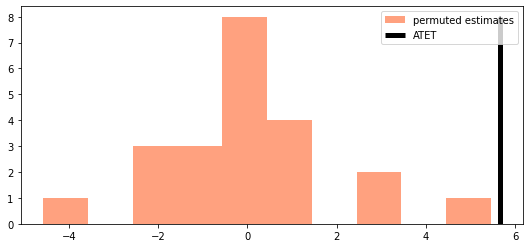

In [14]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(9,4))
a = ax.hist(fischer_exact_test_atet, color='orangered', alpha=0.50, label='permuted estimates')
ax.vlines( sc_output['atet'], 0, a[0].max(), linewidth=5, color='black', label='ATET')
ax.legend()

## Implementation for Difference-in-Differene models
Do the same thing but for difference-in-difference models.

In [15]:
import statsmodels.api as sm

def DiD(X,y, treat_post, fe_list):
    '''
    X           dataframe
    y           array that is our outcome
    treat_post  string name of the treatment unit indicator interacted with post indicator
    fe_list     columns in X that we want to create fixed effects for
    '''
    ## 
    fe_dict = {}
    for f in fe_list:
        fe_dict[f] = pd.get_dummies(X[f], drop_first=True)
    
    fe_X = X.rename({treat_post:'txP'}, axis=1)['txP'].copy()        
    for f in fe_list:
        fe_X = pd.concat([fe_X, fe_dict[f]], axis=1)
    
    dnd = sm.OLS(y,            
           sm.add_constant( fe_X) ).fit()
    ft = dnd.fittedvalues
    ft[(X[treat_post]==1)] -= dnd.params.txP
    return {'est': dnd.params.txP, 'se': dnd.bse.txP, 'pv':dnd.pvalues.txP,
           'yhat':dnd.fittedvalues, 'yhat_0': ft}
    

/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [22]:
import itertools
## Estimate the DnD model    
dnd_output = DiD(X= df,
   y= df['Y'],
   treat_post= 'treatment',
   fe_list = ['unitid','T'])
df['yhat_0'] = dnd_output['yhat_0'].values

treatment_dates = list( df.loc[(df['post']==1)]['T'].unique() )
treat_counterfactual_post = df.loc[(df['treatment_units']==1) &\
                                   (df['T'].isin(treatment_dates))==True].groupby('T')['yhat_0'].mean()
treat_actual_post = df.loc[(df['treatment_units']==1) &\
                           (df['T'].isin(treatment_dates))==True].groupby('T')['Y'].mean()

## Calculate the residual, which is 
## the counterfactual of the treatment in the post period if it were control, and the actual
residual_initial = treat_counterfactual_post - treat_actual_post
S_q_dnd = conformal_inf.test_statS(1, treatment_window, residual_initial)

S_q_pi_dnd = []
## Now do a whole bunch of treatment time scrambles
## Also allow instead to permute over all permutations
for r in permute_scramble_list:
    scrambled_dates = np.array(list(r))

    residual = conformal_inf.scrambled_residual( df.loc[(df['treatment_units']==1)].groupby('T')['yhat_0'].mean(),
                       df.loc[(df['treatment_units']==1)].groupby('T')['Y'].mean(),
                       scrambled_dates,
                       treatment_window)    
# for r in range(200):
#     scrambled_dates = np.random.choice( np.sum(treatment_window),
#                                        np.sum(treatment_window),
#                                        replace=False )
#     residual = scrambled_sc(df, scrambled_dates, treatment_window[1])
    S_q_pi_dnd.append(  conformal_inf.test_statS(1, treatment_window, residual)  )

/Users/hsujulia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


KeyboardInterrupt: 

In [ ]:
p_value = 1 - np.average( (S_q_pi_dnd < S_q_dnd) )
print('pvalue {0:7.5f}'.format(p_value) )
print('Compare to traditional pvalue {0:7.5f}'.format(dnd_output['pv']))

5.661710666569297
9.342739320419234


KeyboardInterrupt: 

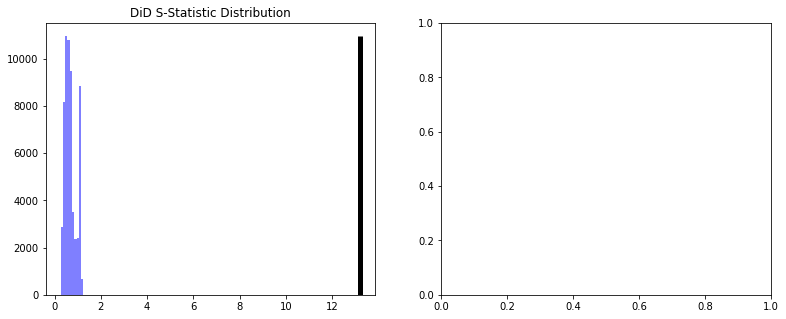

In [24]:
print( sc_output['atet'] )
print( dnd_output['est'] )

fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(13,5))
a0 = ax[0].hist(S_q_pi_dnd, label='DiD S-Statistic', color='blue', alpha=0.50)
ax[0].vlines( S_q_dnd, 0, a0[0].max(), linewidth=5, color='black', label='ATET')
ax[0].set_title('DiD S-Statistic Distribution')

a1 = ax[1].hist(S_q_pi, label='DiD S-Statistic', color='orangered', alpha=0.50)
ax[1].vlines( S_q, 0, a1[0].max(), linewidth=5, color='black', label='ATET')

ax[1].set_title('DiD S-Statistic Distribution')